In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import uproot
import logging

import acts

from pathlib import Path
from itertools import cycle

import awkward as ak

In [43]:
def plot_prototrack(prototrack):
    colors = [ c for i, c in zip(range(len(prototrack)), cycle(matplotlib.colors.TABLEAU_COLORS)) ]
    
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    fig.suptitle("Prototrack with ID {} and lenght {}".format(str(prototrack.trackId.to_list()[0]), len(prototrack)))

    # move around a bit so we see overlaps
    def randomify(x):
        d = max(x) - min(x)
        r = np.random.normal(0,0.01*d,len(x))
        return x + r
    
    ax[0].scatter(randomify(prototrack.z), randomify(np.hypot(prototrack.x, prototrack.y)), color=colors, marker="x")
    ax[1].scatter(randomify(prototrack.x), randomify(prototrack.y), color=colors, marker="x")

    return fig, ax

In [78]:
#base_path = Path("../output/gnn_ckf_no_threshold")
base_path = Path("../output/gnn_ckf_no_threshold/")

In [90]:
particles = ak.to_dataframe(uproot.open("../10events/particles_initial.root:particles").arrays()).reset_index(drop=True)
particles = particles[ particles.event_id == 0 ].copy()

In [86]:
matched_df = pd.read_csv(base_path / "performance_exatrkx.csv")
matched_df = matched_df[ matched_df.event == 0 ].copy()
matched_df["eta"] = matched_df.particle_id.map(dict(zip(particles.particle_id, particles.eta)))
matched_df["pt"] = matched_df.particle_id.map(dict(zip(particles.particle_id, particles.pt)))
matched_df["pix_nhits"] = matched_df.particle_id.map(dict(measurements[ measurements.volume.isin([16,17,18]) ].groupby("particle_id").count().hit_id))

0.8491302804401846

In [114]:
def eff(x):
    return sum(x)/len(x)

eff(matched_df.matched.to_numpy()), eff(matched_df[ matched_df.pt > 1.0 ].matched.to_numpy())

(0.8783634353114633, 0.8818181818181818)

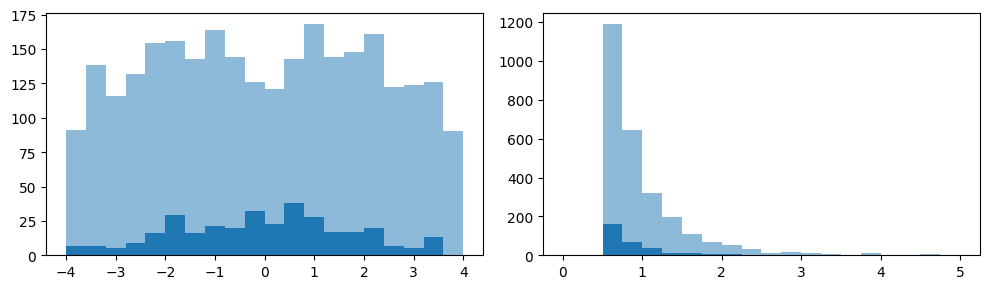

In [119]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
_, bins, _ = ax[0].hist(matched_df.eta, bins=20, range=(-4,4), alpha=0.5)
ax[0].hist(matched_df[ matched_df.matched == 0 ].eta, bins=bins, range=(-4,4), color="tab:blue") 
_, bins, _ = ax[1].hist(matched_df.pt, bins=20, range=(0,5), alpha=0.5)
ax[1].hist(matched_df[ matched_df.matched == 0 ].pt, bins=bins, color="tab:blue")

fig.tight_layout()

In [79]:
prototracks = pd.read_csv(base_path / "exatrkx/event000000000-prototracks.csv")
print(prototracks.shape)
prototracks = prototracks[ ~prototracks.duplicated(["x", "y", "z", "measurementId"]) ].copy()
print(prototracks.shape)

(29685, 5)
(29685, 5)


In [80]:
hits = uproot.open("../10events/hits.root:hits").arrays(library="pd")
hits = hits[ (hits.event_id == 0) & (hits.tt < 25.0) ].copy()
hits["hit_id"] = np.arange(len(hits))
hits.head(2)

simhit_map = pd.read_csv(base_path / "digi/event000000000-measurement-simhit-map.csv")
measId_to_hitID = dict(zip(simhit_map.measurement_id, simhit_map.hit_id))


prototracks["hit_id"] = prototracks["measurementId"].map(measId_to_hitID)
prototracks["tx"] = prototracks.hit_id.map(dict(zip(hits.hit_id, hits.tx)))
prototracks["ty"] = prototracks.hit_id.map(dict(zip(hits.hit_id, hits.ty)))
prototracks["tz"] = prototracks.hit_id.map(dict(zip(hits.hit_id, hits.tz)))
prototracks["geometry_id"] = prototracks.hit_id.map(dict(zip(hits.hit_id, hits.geometry_id)))

hitId_to_particleId = dict(zip(hits.hit_id, hits.particle_id))
prototracks["particle_id"] = prototracks.hit_id.map(hitId_to_particleId)

prototracks.head(2)

,trackId,measurementId,x,y,z,hit_id,tx,ty,tz,geometry_id,particle_id
0,0,3,75.975,-8.125000,-1515.6,3,75.966911,-8.117891,-1515.599976,1152921779484754177,860187531394678784
1,0,2341,66.175,-6.328211,-1315.6,2342,66.162704,-6.349545,-1315.599976,1152921916923707649,860187531394678784


In [81]:
measurements = pd.read_csv(base_path / "digi/event000000000-measurements.csv")
print("all",measurements.shape)
measurements["volume"] = measurements.geometry_id.map(lambda geoid: acts.GeometryIdentifier(geoid).volume())
measurements["hit_id"] = measurements.measurement_id.map(measId_to_hitID)
measurements["particle_id"] = measurements.hit_id.map(hitId_to_particleId)

measurements_pixel = measurements[ measurements.volume.isin([16,17,18]) ].copy()
print("pixel",measurements_pixel.shape)
measurements_pixel.head(2)

all (148722, 13)
pixel (69979, 16)


,measurement_id,geometry_id,local_key,local0,local1,phi,theta,time,var_local0,var_local1,var_phi,var_theta,var_time,volume,hit_id,particle_id
0,0,1152921779484754177,,-4.925,-24.972519,0,0,0,0.000208,0.000208,0,0,0,16,0,891712726538190854
1,1,1152921779484754177,,3.225,-30.625000,0,0,0,0.000208,0.000208,0,0,0,16,1,882705527350493184


In [82]:
prototracks_list = [ df for id, df in prototracks.groupby("trackId") ]
prototracks_list[0]

,trackId,measurementId,x,y,z,hit_id,tx,ty,tz,geometry_id,particle_id
0,0,3,75.975000,-8.125000,-1515.6,3,75.966911,-8.117891,-1515.599976,1152921779484754177,860187531394678784
1,0,2341,66.175000,-6.328211,-1315.6,2342,66.162704,-6.349545,-1315.599976,1152921916923707649,860187531394678784
2,0,4645,56.277414,-4.775001,-1115.6,4646,56.297218,-4.776989,-1115.599976,1152922054362661121,860187531394678784
3,0,6893,49.375000,-3.825001,-975.6,6894,49.388748,-3.810642,-975.599976,1152922191801614593,860187531394678784
4,0,9083,42.425003,-2.975000,-835.6,9084,42.435219,-2.973998,-835.599976,1152922329240568065,860187531394678784


(<Figure size 1000x300 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

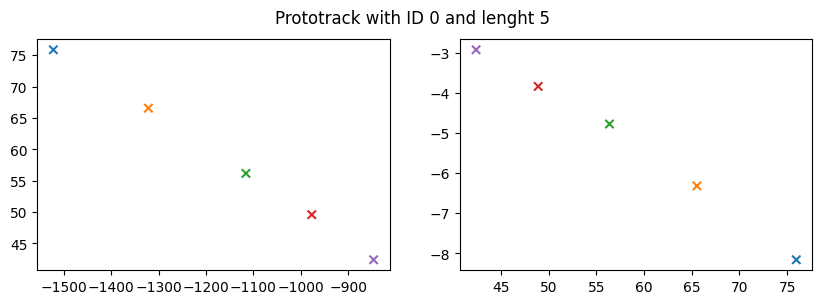

In [83]:
plot_prototrack(prototracks_list[0])

In [120]:
poc_match_df = pd.read_csv(base_path / "performance_proof_of_concept.csv")
poc_match_df = poc_match_df[ poc_match_df.event == 0 ].copy()
sum(poc_match_df.matched)/len(poc_match_df)

0.9630812921547746

In [122]:
poc_success_pids = poc_match_df[ poc_match_df.matched == 1 ].particle_id.to_numpy()
poc_failed_pids = poc_match_df[ poc_match_df.matched == 0 ].particle_id.to_numpy()

In [87]:
# Remove particles that failed in proof of concept -> this should give pure GNN+CKF inefficiency
assert len(poc_match_df) == len(matched_df)
matched_df = matched_df[ matched_df.particle_id.isin(poc_success_pids) ].copy()
len(matched_df)

2713

In [88]:
not_matched = matched_df[ matched_df.matched == 0 ].copy()

df = pd.DataFrame()

for pid in not_matched.particle_id.to_numpy():
    info = {}

    info["particle_id"] = pid
    
    trkMeasurements = measurements_pixel[ measurements_pixel.particle_id == pid ]
    info["nMeasPixel"] = len(trkMeasurements)
    
    trackIds = prototracks[ prototracks.particle_id == pid ].trackId.to_numpy()
    info["nTrackIds"] = len(trackIds)

    trackIds, count = np.unique(trackIds, return_counts=True)
    info["nUniqueTrackIds"] = len(trackIds)

    if len(trackIds) > 0:
        info["majTrackId"] = trackIds[np.argmax(count)]
        info["foundMajTrackIds"] = max(count)

        info["totalMajTrackIds"] = len(prototracks[ prototracks.trackId == info["majTrackId"] ])
    
    
    for k in info.keys():
        info[k] = [ info[k] ]
    
    df = pd.concat([df, pd.DataFrame(info)])

df = df.reset_index(drop=True)
df["pixel_track_eff"] = df.foundMajTrackIds / df.nMeasPixel
df["pixel_track_pur"] = df.foundMajTrackIds / df.totalMajTrackIds
df.head(3)

,particle_id,nMeasPixel,nTrackIds,nUniqueTrackIds,majTrackId,foundMajTrackIds,totalMajTrackIds,pixel_track_eff,pixel_track_pur
0,4503599644147712,7,7,1,3577.0,7.0,13.0,1.0,0.538462
1,4503599811919872,4,4,1,3266.0,4.0,6.0,1.0,0.666667
2,4503600516562944,10,10,1,3810.0,10.0,16.0,1.0,0.625000


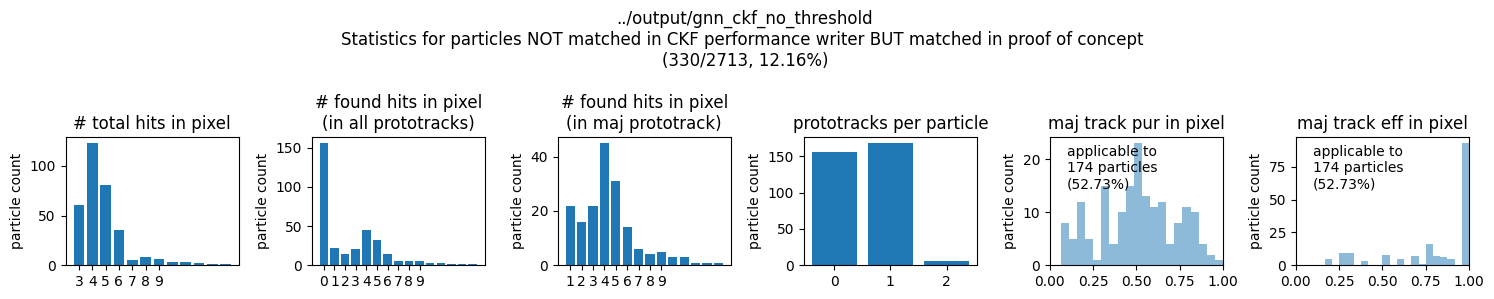

In [89]:
fig, ax = plt.subplots(1,6,figsize=(15,3))

ax[0].bar(*np.unique(df.nMeasPixel, return_counts=True))
ax[0].set_title("# total hits in pixel")
ax[0].set_ylabel("particle count")
ax[0].set_xticks(np.arange(min(df.nMeasPixel), 10))

ax[1].bar(*np.unique(df.nTrackIds, return_counts=True))
ax[1].set_title("# found hits in pixel\n(in all prototracks)")
ax[1].set_ylabel("particle count")
ax[1].set_xticks(np.arange(min(df.nTrackIds), 10))

ax[2].bar(*np.unique(df.foundMajTrackIds, return_counts=True))
ax[2].set_title("# found hits in pixel\n(in maj prototrack)")
ax[2].set_ylabel("particle count")
ax[2].set_xticks(np.arange(min(df.foundMajTrackIds), 10))

ax[3].bar(*np.unique(df.nUniqueTrackIds, return_counts=True))
ax[3].set_title("prototracks per particle")
ax[3].set_ylabel("particle count")
ax[3].set_xticks(np.arange(min(df.nUniqueTrackIds), max(df.nUniqueTrackIds)+1))

nFinite = sum(np.isfinite(df.pixel_track_pur))
ax[4].hist(df.pixel_track_pur, bins=20, alpha=0.5)
ax[4].set_title("maj track pur in pixel")
ax[4].text(0.1,0.6, "applicable to\n{} particles\n({:.2%})".format(nFinite, nFinite/len(df)), transform=ax[4].transAxes)
ax[4].set_ylabel("particle count")
ax[4].set_xlim(0,1)

nFinite = sum(np.isfinite(df.pixel_track_eff))
ax[5].hist(df.pixel_track_eff, bins=20, alpha=0.5)
ax[5].set_title("maj track eff in pixel")
ax[5].text(0.1,0.6, "applicable to\n{} particles\n({:.2%})".format(nFinite, nFinite/len(df)), transform=ax[5].transAxes)
ax[5].set_ylabel("particle count")
ax[5].set_xlim(0,1)

fig.suptitle(
"{}\n"
"Statistics for particles NOT matched in CKF performance writer "
"BUT matched in proof of concept \n({}/{}, {:.2%})".format(str(base_path),
                                                           len(not_matched),
                                                           len(matched_df),
                                                           len(not_matched)/len(matched_df))
)
fig.tight_layout()

In [91]:
df["eta"] = df.particle_id.map(dict(zip(particles.particle_id, particles.eta)))
df["pt"] = df.particle_id.map(dict(zip(particles.particle_id, particles.pt)))
df["pix_nhits"] = df.particle_id.map(dict(measurements[ measurements.volume.isin([16,17,18]) ].groupby("particle_id").count().hit_id))

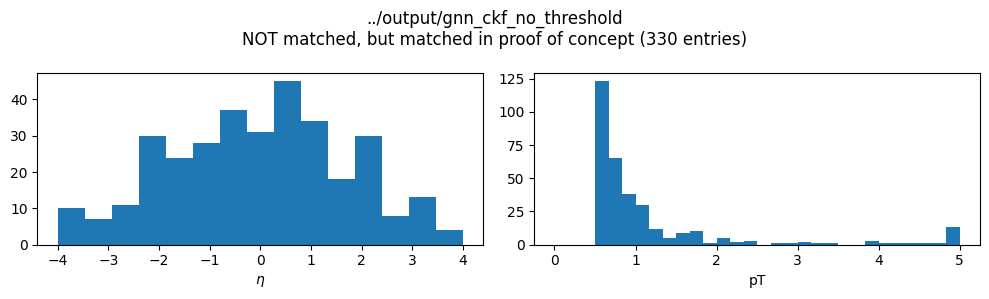

In [92]:
fig, ax = plt.subplots(1,2,figsize=(10,3))

ax[0].hist(df.eta, bins=15, range=(-4,4))
ax[0].set_xlabel("$\eta$")
ax[1].hist(np.clip(df.pt,0,5), bins=30, range=(0,5))
ax[1].set_xlabel("pT")
#ax[2].bar(*np.unique(df.pix_nhits, return_counts=True))
#ax[2].set_xlabel("pixel nHits")
#ax[2].set_xticks(np.arange(10))
#ax[3].bar(*np.unique(df.nTrackIds, return_counts=True))
#ax[3].set_xlabel("associated proto track length")
#ax[3].set_xticks(np.arange(10))

fig.suptitle(f"{base_path}\nNOT matched, but matched in proof of concept ({len(df)} entries)")
fig.tight_layout()

In [93]:
sum(df.pt > 0.5), sum(df.pt > 1.0)

(330, 104)

In [94]:
"Number of umatched with 100% pur and efficient prototrack", len(df[ (df.pixel_track_eff == 1.0) & (df.pixel_track_pur == 1.0) ])

('Number of umatched with 100% pur and efficient prototrack', 0)